let's see how long does it to run for one col

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.data import random_split
from sklearn.preprocessing import minmax_scale

In [2]:
datetime.now().strftime("%H:%M:%S")

'16:46:34'

In [3]:
data = pd.read_csv('data.csv')
data.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [4]:
colF4 = [col for col in data.columns if col[0:3]=='F_4']
data = data[colF4]
data.head()

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,NaN,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


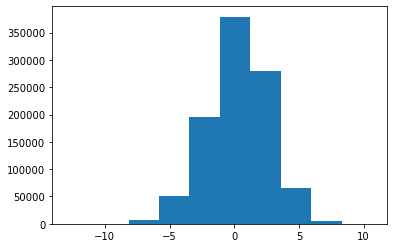

In [5]:
plt.hist(data.values[:,0]);

In [6]:
X_norm = minmax_scale(data.values, feature_range=(-1,1), axis=0)

(array([8.00000e+00, 3.90000e+02, 6.64500e+03, 5.00040e+04, 1.95823e+05,
        3.78967e+05, 2.79121e+05, 6.58650e+04, 4.92000e+03, 1.29000e+02]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
        -2.00000000e-01, -1.11022302e-16,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

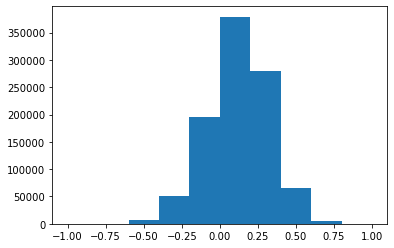

In [16]:
plt.hist(X_norm[:,0])

In [8]:
X = X_norm[np.sum(np.isnan(X_norm), axis=1)==0]
X.shape

(759268, 15)

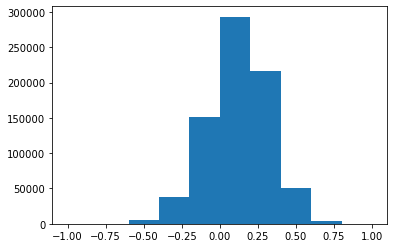

In [9]:
plt.hist(X[:,0]);

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, icol):
        self.X = X
        self.icol = icol
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.Tensor(np.hstack((self.X[idx,:self.icol], self.X[idx,(self.icol+1):]))), torch.Tensor([self.X[idx,self.icol]])

In [11]:
class Model(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.bn2 = nn.BatchNorm1d(hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.bn2(self.activation(self.fc2(x)))
        x = self.bn3(self.activation(self.fc3(x)))
        return nn.Tanh()(self.fc4(x))

In [ ]:
# def val(model, dataloader):
#     criteria = nn.MSELoss()
#     model.eval()
#     with torch.no_grad():
#         loss_mean = 0
#         loss_median = 0
#         for X, y in dataloader:
#             predict = model(X)
#             loss = criteria(predict, y)
#             loss_mean += loss.item() * X.shape[0]
#             loss_median = (predict-y).abs().median().item() * X.shape[0]
#     return loss_mean / len(dataloader.dataset), loss_median / len(dataloader.dataset)

In [12]:
def val(model, dataloader):
    criteria = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        loss_mean = 0
        for X, y in dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            loss_mean += loss.item() * X.shape[0]
    return loss_mean / len(dataloader.dataset)

In [13]:
def train(dataset, savename, epoches=1000, earlystop_patience=10):
    model = Model()
    
    n = len(dataset)
    n1 = int(0.9*n)
    n2 = n - n1
    train_dataset, val_dataset = random_split(dataset, [n1,n2])
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, drop_last=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    criteria = nn.MSELoss()
    
#     print(f'starting loss={val(model, train_dataloader)}')
    
    val_loss_min = 100.
    best_epoch = 0
    
    for epoch in range(epoches):
        
        print(f'lr={optimizer.param_groups[0]["lr"]}')
        
        if epoch - best_epoch > earlystop_patience:
            print('early stop')
            break
        
        model.train()

        loss_mean = 0
        for X, y in train_dataloader:
            predict = model(X)
            loss = criteria(predict, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * X.shape[0]
        
        loss_mean /= len(train_dataloader.dataset)
        val_loss = val(model, val_dataloader)
        print(f"{datetime.now().strftime('%H:%M:%S')}-epoch {epoch}: training loss={loss_mean}, validation loss={val_loss}")
        scheduler.step(val_loss)
        
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save({'model':model.state_dict()}, savename)

In [14]:
X.shape

(759268, 15)

In [15]:
for icol in range(15):
    print(f"======== doing {icol}  ========")
    mydataset = MyDataset(X, icol)
    train(mydataset, f'model_0_{icol}.pickle')

======== doing 0  ========
lr=0.01
16:48:44-epoch 0: training loss=0.008487130068554217, validation loss=0.0009343328565770187
lr=0.01
16:49:10-epoch 1: training loss=0.0010040643088908565, validation loss=0.0015879114099675827
lr=0.01
16:49:37-epoch 2: training loss=0.0007539793978368366, validation loss=0.0020160821313034176
lr=0.01
16:50:03-epoch 3: training loss=0.0006135892766319811, validation loss=0.0022179759726197817
lr=0.01
16:50:30-epoch 4: training loss=0.000561863747210987, validation loss=0.0018144342159430533
lr=0.01
16:50:56-epoch 5: training loss=0.0004949894132841215, validation loss=0.001657128652505183
lr=0.01
16:51:23-epoch 6: training loss=0.0004982561465858577, validation loss=0.033117789995087514
lr=0.001
16:51:50-epoch 7: training loss=0.000197593023758129, validation loss=0.00015446797724268422
lr=0.001
16:52:17-epoch 8: training loss=0.0001934763520701734, validation loss=7.396822271525202e-05
lr=0.001
16:52:45-epoch 9: training loss=0.00019417475289700277, v

17:28:15-epoch 4: training loss=0.00022262797664110282, validation loss=0.00024242385341799832
lr=0.01
17:28:47-epoch 5: training loss=0.00017166479398365283, validation loss=0.00018587709801635375
lr=0.01
17:29:21-epoch 6: training loss=0.00010869820668855162, validation loss=7.249272541690239e-05
lr=0.01
17:29:53-epoch 7: training loss=0.00011621891412633981, validation loss=0.00014016902198593002
lr=0.01
17:30:25-epoch 8: training loss=0.00010079381013508092, validation loss=9.756467446929419e-05
lr=0.01
17:30:56-epoch 9: training loss=0.00010611438889350737, validation loss=0.0003110032570399676
lr=0.01
17:31:31-epoch 10: training loss=0.00018793567499596867, validation loss=0.00018258695366388104
lr=0.01
17:32:05-epoch 11: training loss=0.00010747760811608535, validation loss=5.282336829449618e-05
lr=0.01
17:32:40-epoch 12: training loss=9.579155858594046e-05, validation loss=6.334081314355062e-05
lr=0.01
17:33:14-epoch 13: training loss=9.00877530306169e-05, validation loss=7.875

18:23:34-epoch 52: training loss=7.672638834266043e-05, validation loss=2.194385271064711e-05
lr=1.0000000000000002e-06
18:24:09-epoch 53: training loss=7.56380675676744e-05, validation loss=2.1288775561896365e-05
lr=1.0000000000000002e-06
18:24:45-epoch 54: training loss=7.532532705087514e-05, validation loss=2.2349154079680833e-05
lr=1.0000000000000002e-06
18:25:20-epoch 55: training loss=7.393915440072293e-05, validation loss=2.226036812659704e-05
lr=1.0000000000000002e-06
early stop
======== doing 4  ========
lr=0.01
18:25:53-epoch 0: training loss=0.0082659094560964, validation loss=0.00026423101402725725
lr=0.01
18:26:27-epoch 1: training loss=0.0005141172884984318, validation loss=0.0005497267237643008
lr=0.01
18:27:00-epoch 2: training loss=0.0003309155522909378, validation loss=0.0007510494424254788
lr=0.01
18:27:32-epoch 3: training loss=0.00029762641759523557, validation loss=0.000128705625211081
lr=0.01
18:28:05-epoch 4: training loss=0.0002441832043886806, validation loss=

19:07:38-epoch 37: training loss=6.844146782862632e-05, validation loss=9.485370228946864e-05
lr=1e-05
19:08:10-epoch 38: training loss=6.150793552022238e-05, validation loss=0.00010274933621269713
lr=1e-05
19:08:43-epoch 39: training loss=6.072666116790876e-05, validation loss=0.0001338760246896425
lr=1e-05
19:09:16-epoch 40: training loss=6.700432270542488e-05, validation loss=6.556807441618631e-05
lr=1e-05
19:09:48-epoch 41: training loss=6.049530344730755e-05, validation loss=0.00015913820883005432
lr=1e-05
early stop
======== doing 6  ========
lr=0.01
19:10:21-epoch 0: training loss=0.012201110829799579, validation loss=0.004246037775647652
lr=0.01
19:10:53-epoch 1: training loss=0.001657045987489036, validation loss=0.0010222547202197398
lr=0.01
19:11:26-epoch 2: training loss=0.0011916067492261796, validation loss=0.0013144779531035554
lr=0.01
19:11:58-epoch 3: training loss=0.0009835657079810148, validation loss=0.0022253751284659153
lr=0.01
19:12:31-epoch 4: training loss=0.00

20:13:49-epoch 12: training loss=6.267854921822569e-05, validation loss=0.0001446957406152612
lr=0.01
20:14:18-epoch 13: training loss=6.508459967933332e-05, validation loss=0.00011641069609157875
lr=0.01
20:14:48-epoch 14: training loss=5.820252818930352e-05, validation loss=0.00019067230108310739
lr=0.01
20:15:18-epoch 15: training loss=7.499727730143794e-05, validation loss=0.00011546020690877315
lr=0.001
20:15:48-epoch 16: training loss=3.4012002581152223e-05, validation loss=0.0001484378427847835
lr=0.001
20:16:18-epoch 17: training loss=3.1506903953417795e-05, validation loss=0.00010735401985318548
lr=0.001
20:16:47-epoch 18: training loss=3.3736365029379e-05, validation loss=8.588166296797178e-05
lr=0.001
20:17:19-epoch 19: training loss=3.333191055364816e-05, validation loss=0.00012369757978309383
lr=0.001
early stop
======== doing 9  ========
lr=0.01
20:17:47-epoch 0: training loss=0.01431980059312857, validation loss=0.001232553594761764
lr=0.01
20:18:15-epoch 1: training los

20:52:29-epoch 24: training loss=3.070696208215435e-05, validation loss=7.997211712923417e-06
lr=0.001
20:53:02-epoch 25: training loss=3.095815360138181e-05, validation loss=3.0451429270769105e-05
lr=0.001
20:53:34-epoch 26: training loss=3.1335961578437254e-05, validation loss=0.00015923916045367241
lr=0.001
20:54:05-epoch 27: training loss=3.139263893497791e-05, validation loss=1.2308641435092564e-05
lr=0.001
20:54:35-epoch 28: training loss=3.0721379638856314e-05, validation loss=3.959964833512294e-05
lr=0.001
20:55:06-epoch 29: training loss=3.227251421046408e-05, validation loss=0.00011758018452512289
lr=0.001
20:55:36-epoch 30: training loss=3.072435274355895e-05, validation loss=0.00010554667243430572
lr=0.0001
20:56:06-epoch 31: training loss=2.5682161653798135e-05, validation loss=9.294960370949436e-05
lr=0.0001
20:56:37-epoch 32: training loss=2.6185546208049738e-05, validation loss=9.244676474312043e-05
lr=0.0001
20:57:09-epoch 33: training loss=2.6605159391051857e-05, vali

21:35:00-epoch 11: training loss=0.00017434656001379977, validation loss=0.0002483791428383662
lr=0.01
21:35:38-epoch 12: training loss=0.00019184329576703228, validation loss=5.862526978192856e-05
lr=0.01
21:36:16-epoch 13: training loss=0.00016920948722014555, validation loss=0.00013298716501051455
lr=0.01
21:36:53-epoch 14: training loss=0.00020483722631940788, validation loss=0.000107058443436483
lr=0.01
21:37:31-epoch 15: training loss=0.00017933566989476455, validation loss=6.354358531858944e-05
lr=0.001
21:38:09-epoch 16: training loss=8.979076193453905e-05, validation loss=5.9563892807256496e-05
lr=0.001
21:38:48-epoch 17: training loss=9.079567205045375e-05, validation loss=3.720058506038088e-05
lr=0.001
21:39:29-epoch 18: training loss=8.784976395927679e-05, validation loss=0.0001268940173327042
lr=0.001
21:40:13-epoch 19: training loss=9.156989670570214e-05, validation loss=7.977880314756582e-05
lr=0.001
21:40:58-epoch 20: training loss=8.298120061395771e-05, validation loss